# Lab CNN

Create a CNN that can classify flower types

## importing relevant packages for pre processing

In [125]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_tuner



## Pre processing the data set

In [126]:
data_dir = pathlib.Path("Data/flowers") # Setting directory path as a variable for the flowers data set

In [127]:
image_count =len(list(data_dir.glob("*/*.jpg"))) # Doing an image count to check the amount of images within the dataset
image_count

4317

In [128]:
list(data_dir.glob("*/*.jpg"))[0:2] # Listing some of the images, This is instance [0:2] is the first folder and first 2 images

[PosixPath('Data/flowers/daisy/5435521200_92029bbe2b_n.jpg'),
 PosixPath('Data/flowers/daisy/34518066912_0e432507bc_n.jpg')]

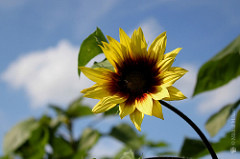

In [129]:
# checking to see if the images get displayed
sunflower = list(data_dir.glob("sunflower/*"))
PIL.Image.open(str(sunflower[0])) # checking first image in sunflower folder

### Creating and splitting the data set using keras utilities  

In [130]:
# I will have a few parameters that can change within the function these will include batch size, image width and height
# I will split the data in to a train at 80% and val 

def train_test_split(batch_size, img_width, img_height):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "training",
        seed = 123,
        image_size = (img_width, img_height),
        batch_size = batch_size,
        labels="inferred",
        label_mode="categorical",
        shuffle=True)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "validation",
        seed = 123,
        image_size = (img_width, img_height),
        batch_size = batch_size,
        labels="inferred",
        label_mode="categorical",
        shuffle=True)
    
    # cardinality will now calculate the size of the validation dataset so that I can half it for the test dataset
    #val_batches = tf.data.experimental.cardinality(val_ds)
    #test_size = val_batches // 2 # test df is half of validation

    # Will now create the test dataset by taking half of the validation data set
    #test_ds = val_ds.take(test_size)

    # Adjusting the validation so that it will skip the test dataset
    #val_ds = val_ds.skip(test_size)

    return train_ds,test_ds


In [131]:
# testing the function with batchsize 32, height 180 and 180
train_ds, test_ds = train_test_split(32,180,180)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [132]:
# checking to see the sizes of the train, val and test sets and at what shape they are

print("Training Dataset:")
print("Number of batches:", len(train_ds))
print("Shape of a single batch:", train_ds.element_spec)

print("\nTest Dataset:")
print("Number of batches:", len(test_ds))
print("Shape of a single batch:", test_ds.element_spec)
  

Training Dataset:
Number of batches: 108
Shape of a single batch: (TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

Test Dataset:
Number of batches: 27
Shape of a single batch: (TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))


In [133]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 5)


In [134]:
# I need to also add class names so that the data has labels

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


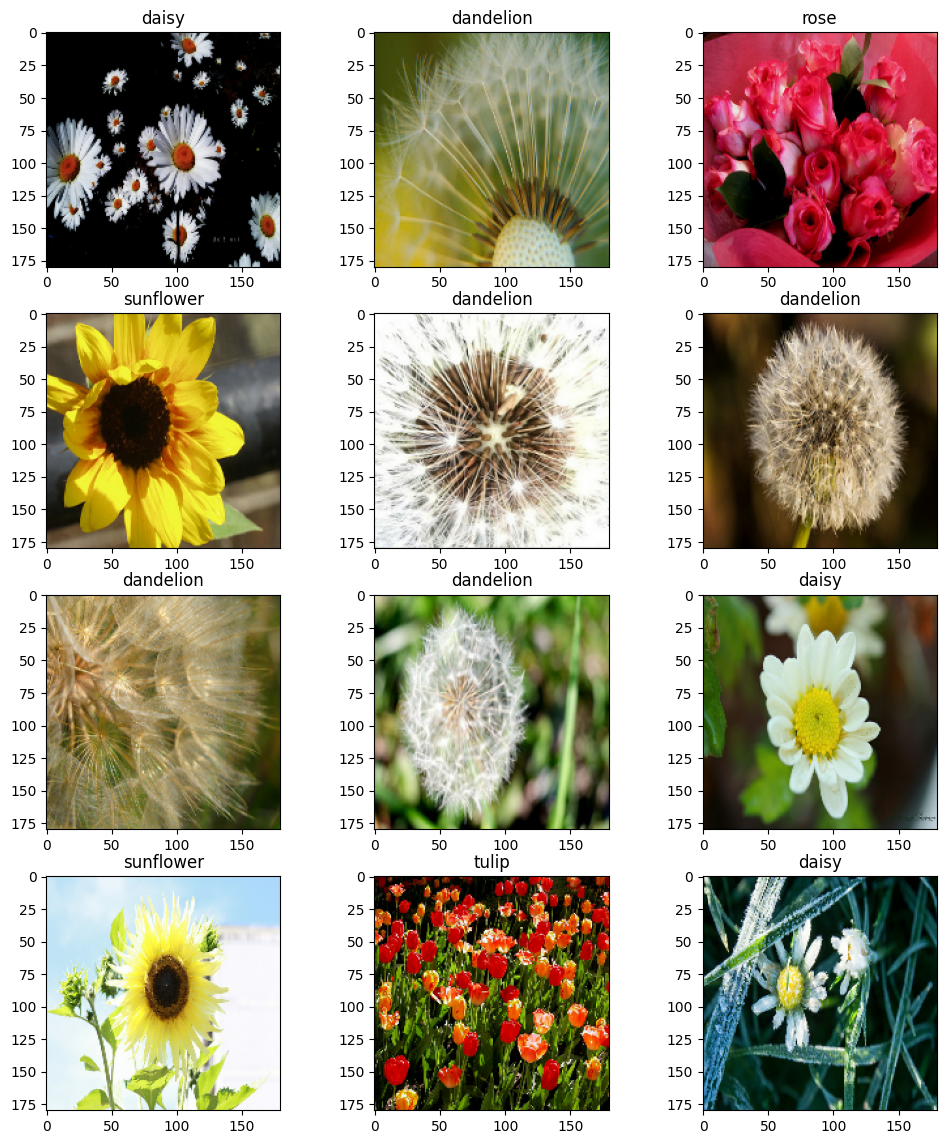

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,14))
for images, labels in train_ds.take(1):
    for i in range (12):
        ax = plt.subplot(4,3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        class_index = np.argmax(labels[i])

        plt.title(class_names[class_index])
        

## Building the model

I am going to use keras tuner to help find the best hyper parameters for my model. First i have to build a function that will have the different parameters that i will try to build the best model 

In [140]:
img_height = 180
img_width = 180


def model_builder(hp):
    model = tf.keras.Sequential()
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) # rescaling the images so they are between 0 and 1

    # input layer 
    model.add(layers.Conv2D
              (filters = hp.Int("input", min_value =32, max_value=256, step=16)),
              kernel_size= hp.Choice("input", values= [3,5]),
              activation= hp.Choice("input", values= ["relu", "tanh"]),
              padding="same", # puts 0 around the image!
              input_shape =(img_height,img_width,3)
              )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # convolution network layers : I will use a for loop that will determine what the best amount of layers will be for the model using the keras tuner
    for i in range(hp.Int("n_layers")):
        model.add(layers.Conv2D
                  (filters = hp.Int(f"conv_{i}", min_value=32, max_value=256, step=16)),
                  kernel_size = hp.Int(f"conv_{i}", values= [3,5]),
                  activation=hp.Choice(f"conv_{i}", values=["relu", "tanh"]),
                  padding="same"
                  )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    for i in range(hp.Int("n_connections", 1,4)):
        model.add(layers.Dense(
                  units=hp.Choice(f"n_nodes", values = [128, 256, 512, 1024]),
                  activation=hp.Choice(f"n_nodes", values=["relu", "tanh"])))
        
    model.add(layers.Dense(5))
    
    model.add(layers.Activation("softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values= [1e-2, 1e-3, 1e-4])),
                  loss= keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

    
    